In [12]:
import numpy as np
import pandas as pd
import seaborn as sns


import csv

import os 
import sklearn
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
data_multi = pd.read_feather('/home/rbarreto/data/scaled-facets-multi-50k-v4.feather')
data_multi.head(5)

,sentiment,respect,insult,humiliate,status,dehumanize,violence_phys,genocide,attack_defend,hatespeech,...,demo_sexual_orien_2,demo_sexual_orien_3,demo_sexual_orien_4,demo_sexual_orien_5,demo_sexual_orien_4_text,demo_ideology,locationlatitude,locationlongitude,identity,hypothesis
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,,4.0,37.55029296875,-77.39420318603515625,0.917681,-1.130178
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,,4.0,32.9568939208984375,-96.83170318603515625,0.918119,-1.146973
2,4.0,4.0,3.0,2.0,1.0,1.0,0.0,0.0,3.0,1.0,...,NaN,NaN,NaN,NaN,,5.0,39.3361053466796875,-76.53890228271484375,0.985910,-0.207369
3,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,NaN,NaN,NaN,NaN,,4.0,37.1439971923828125,-94.4727020263671875,0.969761,-0.055536
4,4.0,4.0,3.0,2.0,1.0,1.0,1.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,,4.0,34.215301513671875,-79.64679718017578125,0.935462,0.104225


In [3]:
data_multi.columns.values

array(['sentiment', 'respect', 'insult', 'humiliate', 'status',
       'dehumanize', 'violence_phys', 'genocide', 'attack_defend',
       'hatespeech', 'comment_id', 'platform', 'uid', 'predict_text',
       'measure', 'std_err', 'num_ratings', 'weight', 'has_targets',
       'target_identity_count', 'labeler_id', 'rater_measure',
       'rater_infitms', 'rater_outfitms', 'infitms', 'outfitms',
       'target_identities_1', 'target_identities_2',
       'target_identities_3', 'target_identities_4',
       'target_identities_5', 'target_identities_6',
       'target_identities_7', 'target_identities_9', 'target_race_1',
       'target_race_2', 'target_race_3', 'target_race_8', 'target_race_4',
       'target_race_5', 'target_race_6', 'target_race_7',
       'target_race_7_text', 'target_religion_1', 'target_religion_2',
       'target_religion_4', 'target_religion_5', 'target_religion_8',
       'target_religion_9', 'target_religion_10', 'target_religion_6',
       'target_religion_6_te

## Sentiment Score by NLTK VADER

In [14]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/rbarreto/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
data_multi['polarity'] = data_multi['predict_text'].map(lambda x:sia.polarity_scores(x))

In [16]:
from random import shuffle

def is_positive(text:str) -> bool:
    """True if text has positive compound statement, False otherwise"""
    return sia.polarity_scores(text)["compound"] > 0

for text in data_multi['predict_text'][:10]:
    print(">", is_positive(text), text)

> True Yes indeed. She sort of reminds me of the elder lady that played the part in the movie "Titanic" who was telling her story!!! And I wouldn't have wanted to cover who I really am!! I would be proud!!!! WE should be proud of our race no matter what it is!!
> True The trans women reading this tweet right now is beautiful
> False Question: These 4 broads who criticize America, what country did they flee to get here? And now they want to make OUR America like THEIR former HELL HOLE. I don't think so!!!!!!!!!!  Let them explain their GRATITUDE for letting them in OUR country.
> True It is about time for all illegals to go back to their country of origin and keep our freeway open and prevent heavy traffic.
> False For starters bend over the one in pink and kick that ass and pussy to get a taste until she's begging for a dick inside her.
> False Sounds like the kinda wholsesome life I'd die for ❤️ never met any black Lesbians before so i guess you're my first ever.
> False Who the fuck 

In [17]:
data_multi['polarity_binary'] = data_multi['predict_text'].map(lambda x:is_positive(x))

In [18]:
labels_polarity = []
for boolean in data_multi['polarity_binary']:
    if boolean == True:
        labels_polarity.append(1)
    else:
        labels_polarity.append(0)

In [19]:
data_multi['labels_polarity'] = labels_polarity

In [22]:
def label_race(row):
    if (row['demo_race_ethnicitie_1'] + row['demo_race_ethnicitie_2'] + 
    row['demo_race_ethnicitie_3'] + row['demo_race_ethnicitie_4'] + 
    row['demo_race_ethnicitie_5'] + row['demo_race_ethnicitie_6'] + 
    row['demo_race_ethnicitie_7'] + row['demo_race_ethnicitie_8'] > 1):
        return 'two or more races'
    if row['demo_race_ethnicitie_1'] == 1:
        return 'american indian alaska native'
    if row['demo_race_ethnicitie_2'] == 1:
        return 'asian'
    if row['demo_race_ethnicitie_3'] == 1:
        return 'black'
    if row['demo_race_ethnicitie_4'] == 1:
        return 'latino'
    if row['demo_race_ethnicitie_5'] == 1:
        return 'native hawaiian pacific islander'
    if row['demo_race_ethnicitie_6'] == 1:
        return 'white'
    if row['demo_race_ethnicitie_7'] == 1:
        return 'other race'
    if row['demo_race_ethnicitie_8'] == 1:
        return 'middle eastern'
    return 'unknown'

In [23]:
data_multi['race_label'] = data_multi.replace(np.nan, 0).apply(label_race, axis=1) #axis =1 means application is done at row rather than column lelvel

## Logistic Regression on Data Targeted by Race

In [24]:
data_multi['target_identities_1'].value_counts()

1.0    48359
Name: target_identities_1, dtype: int64

In [11]:
len(data_multi)

135556

In [25]:
data_race = data_multi[data_multi['target_identities_1'] == 1]

In [26]:
len(data_race)

48359

In [27]:
X_2 = data_race

In [28]:
#black labeler, black target
X_2['black_labeler_black_target'] = X_2['target_race_1'] * X_2['demo_race_ethnicitie_3']

#white labeler, black target

X_2['white_labeler_black_target'] = X_2['target_race_1'] * X_2['demo_race_ethnicitie_6']

#black labeler, white target

X_2['black_labeler_white_target'] = X_2['target_race_6'] * X_2['demo_race_ethnicitie_3']

#white labeler, white target

X_2['white_labeler_white_target'] = X_2['target_race_6'] * X_2['demo_race_ethnicitie_6']

<ipython-input-28-961b824b6a88>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2['black_labeler_black_target'] = X_2['target_race_1'] * X_2['demo_race_ethnicitie_3']
<ipython-input-28-961b824b6a88>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_2['white_labeler_black_target'] = X_2['target_race_1'] * X_2['demo_race_ethnicitie_6']
<ipython-input-28-961b824b6a88>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [29]:
X_2.columns.values

array(['sentiment', 'respect', 'insult', 'humiliate', 'status',
       'dehumanize', 'violence_phys', 'genocide', 'attack_defend',
       'hatespeech', 'comment_id', 'platform', 'uid', 'predict_text',
       'measure', 'std_err', 'num_ratings', 'weight', 'has_targets',
       'target_identity_count', 'labeler_id', 'rater_measure',
       'rater_infitms', 'rater_outfitms', 'infitms', 'outfitms',
       'target_identities_1', 'target_identities_2',
       'target_identities_3', 'target_identities_4',
       'target_identities_5', 'target_identities_6',
       'target_identities_7', 'target_identities_9', 'target_race_1',
       'target_race_2', 'target_race_3', 'target_race_8', 'target_race_4',
       'target_race_5', 'target_race_6', 'target_race_7',
       'target_race_7_text', 'target_religion_1', 'target_religion_2',
       'target_religion_4', 'target_religion_5', 'target_religion_8',
       'target_religion_9', 'target_religion_10', 'target_religion_6',
       'target_religion_6_te

In [30]:
features = ['target_race_1', 'target_race_2', 'target_race_3', 'target_race_4', 'target_race_5', 'target_race_6',
            'demo_race_ethnicitie_1', 'demo_race_ethnicitie_2', 'demo_race_ethnicitie_3', 'demo_race_ethnicitie_4',
            'demo_race_ethnicitie_5', 'demo_race_ethnicitie_6', 'black_labeler_black_target', 'white_labeler_black_target',
            'labels_polarity']

In [31]:
X_2 = X_2[features]

In [32]:
X_2.columns

Index(['target_race_1', 'target_race_2', 'target_race_3', 'target_race_4',
       'target_race_5', 'target_race_6', 'demo_race_ethnicitie_1',
       'demo_race_ethnicitie_2', 'demo_race_ethnicitie_3',
       'demo_race_ethnicitie_4', 'demo_race_ethnicitie_5',
       'demo_race_ethnicitie_6', 'black_labeler_black_target',
       'white_labeler_black_target', 'labels_polarity'],
      dtype='object')

In [33]:
log_reg = LogisticRegression()

In [34]:
y = data_multi[data_multi['target_identities_1'] == 1]['dehumanize'].values
y

array([0., 0., 1., ..., 0., 0., 0.])

In [35]:
X_2 = pd.get_dummies(X_2)
X_2

,target_race_1,target_race_2,target_race_3,target_race_4,target_race_5,target_race_6,demo_race_ethnicitie_1,demo_race_ethnicitie_2,demo_race_ethnicitie_3,demo_race_ethnicitie_4,demo_race_ethnicitie_5,demo_race_ethnicitie_6,black_labeler_black_target,white_labeler_black_target,labels_polarity
0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1
5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0
6,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0
14,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0
135548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1
135549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0
135550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0


In [36]:
X_2 = X_2.fillna(0)

In [37]:
#making train test split here 
X_2_train, X_2_test, y_train, y_test = train_test_split(X_2, y, test_size = .25)

In [38]:
log_reg.fit(X_2_train, y_train)

LogisticRegression()

In [39]:
log_reg.coef_

array([[ 0.06323651,  0.53804321,  0.31561404, -1.22787615, -0.4012416 ,
        -0.68275751, -0.10340538, -0.07544181, -0.19389152, -0.03819315,
         0.09324866, -0.12956404,  0.18871961,  0.00693671, -1.06019905]])

In [40]:
print(log_reg.score(X_2_train, y_train))

0.615098293308335


In [41]:
print(log_reg.score(X_2_test, y_test))

0.6152191894127378


In [42]:
results = sm.Logit(y_train, X_2_train).fit()

Optimization terminated successfully.
         Current function value: 0.643344
         Iterations 5


In [34]:
print(results.summary())


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                36269
Model:                          Logit   Df Residuals:                    36254
Method:                           MLE   Df Model:                           14
Date:                Tue, 21 Sep 2021   Pseudo R-squ.:                 0.06101
Time:                        14:07:41   Log-Likelihood:                -23323.
converged:                       True   LL-Null:                       -24839.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
target_race_1                  0.0707      0.053      1.324      0.185      -0.034       0.175
target_race_2                  0.5552      0.032     17.280      0.000       0.492 

### Logistic Regression on Data Targeting Black 

In [38]:
data_black = data_multi[data_multi['target_race_1'] == 1]

In [39]:
X_2 = data_black

In [43]:
features = ['demo_race_ethnicitie_1', 'demo_race_ethnicitie_2', 'demo_race_ethnicitie_3', 'demo_race_ethnicitie_4', 'demo_race_ethnicitie_5', 'demo_race_ethnicitie_6', 'labels_polarity']

In [44]:
X_2 = X_2[features]

In [46]:
X_2.columns.values

array(['demo_race_ethnicitie_1', 'demo_race_ethnicitie_2',
       'demo_race_ethnicitie_3', 'demo_race_ethnicitie_4',
       'demo_race_ethnicitie_5', 'demo_race_ethnicitie_6',
       'labels_polarity'], dtype=object)

In [49]:
y = data_multi[data_multi['target_race_1'] == 1]['dehumanize'].values
y


array([0., 0., 0., ..., 0., 0., 0.])

In [50]:
print(len(y))
print(len(X_2))

22899
22899


In [51]:
X_2 = pd.get_dummies(X_2)
X_2

,demo_race_ethnicitie_1,demo_race_ethnicitie_2,demo_race_ethnicitie_3,demo_race_ethnicitie_4,demo_race_ethnicitie_5,demo_race_ethnicitie_6,labels_polarity
0,NaN,NaN,NaN,NaN,NaN,1.0,1
5,NaN,NaN,NaN,NaN,NaN,1.0,0
20,NaN,NaN,NaN,1.0,NaN,1.0,0
21,NaN,NaN,NaN,NaN,NaN,1.0,0
22,NaN,NaN,NaN,NaN,NaN,1.0,0
...,...,...,...,...,...,...,...
135346,NaN,NaN,NaN,NaN,NaN,1.0,1
135381,NaN,NaN,1.0,NaN,NaN,NaN,1
135415,NaN,NaN,NaN,NaN,NaN,1.0,1
135467,NaN,NaN,NaN,NaN,NaN,1.0,1


In [52]:
X_2 = X_2.fillna(0)

In [53]:
#making train test split here 
X_2_train, X_2_test, y_train, y_test = train_test_split(X_2, y, test_size = .25)

In [54]:
log_reg.fit(X_2_train, y_train)

LogisticRegression()

In [55]:
log_reg.coef_

array([[-0.17877284, -0.11121885, -0.00350741, -0.0560917 , -0.2357716 ,
        -0.08726867, -0.7056091 ]])

In [56]:
print(log_reg.score(X_2_train, y_train))

0.5504832886922092


In [57]:
print(log_reg.score(X_2_test, y_test))

0.5407860262008733


In [58]:
results = sm.Logit(y_train, X_2_train).fit()

Optimization terminated successfully.
         Current function value: 0.678499
         Iterations 5


In [59]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                17174
Model:                          Logit   Df Residuals:                    17167
Method:                           MLE   Df Model:                            6
Date:                Tue, 21 Sep 2021   Pseudo R-squ.:                 0.01356
Time:                        14:46:16   Log-Likelihood:                -11653.
converged:                       True   LL-Null:                       -11813.
Covariance Type:            nonrobust   LLR p-value:                 3.501e-66
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
demo_race_ethnicitie_1    -0.1800      0.115     -1.572      0.116      -0.404       0.044
demo_race_ethnicitie_2    -0.1019      0.060     -1.696      0.090      -0.220       0.016
demo

In [ ]:
#how do we explore the impact of location on decisions?

#how can i see what the full items options are and include them in the y

In [43]:
data_multi.columns.values

array(['sentiment', 'respect', 'insult', 'humiliate', 'status',
       'dehumanize', 'violence_phys', 'genocide', 'attack_defend',
       'hatespeech', 'comment_id', 'platform', 'uid', 'predict_text',
       'measure', 'std_err', 'num_ratings', 'weight', 'has_targets',
       'target_identity_count', 'labeler_id', 'rater_measure',
       'rater_infitms', 'rater_outfitms', 'infitms', 'outfitms',
       'target_identities_1', 'target_identities_2',
       'target_identities_3', 'target_identities_4',
       'target_identities_5', 'target_identities_6',
       'target_identities_7', 'target_identities_9', 'target_race_1',
       'target_race_2', 'target_race_3', 'target_race_8', 'target_race_4',
       'target_race_5', 'target_race_6', 'target_race_7',
       'target_race_7_text', 'target_religion_1', 'target_religion_2',
       'target_religion_4', 'target_religion_5', 'target_religion_8',
       'target_religion_9', 'target_religion_10', 'target_religion_6',
       'target_religion_6_te

In [44]:
items =['sentiment', 'respect', 'insult', 'humiliate', 'status',
       'dehumanize', 'violence_phys', 'genocide', 'attack_defend',
       'hatespeech']

for i in items:
    print(i, data_multi[i].value_counts(dropna=False))

sentiment 4.0    61435
3.0    35243
2.0    19785
0.0     9658
1.0     9435
Name: sentiment, dtype: int64
respect 4.0    58473
3.0    30720
2.0    23895
0.0    12839
1.0     9629
Name: respect, dtype: int64
insult 3.0    44153
2.0    39673
0.0    33143
1.0    18587
Name: insult, dtype: int64
humiliate 0.0    65896
1.0    39382
2.0    30278
Name: humiliate, dtype: int64
status 1.0    68913
0.0    66643
Name: status, dtype: int64
dehumanize 0.0    85581
1.0    49975
Name: dehumanize, dtype: int64
violence_phys 0.0    110890
1.0     24666
Name: violence_phys, dtype: int64
genocide 0.0    121003
1.0     14553
Name: genocide, dtype: int64
attack_defend 2.0    44883
1.0    38201
3.0    33468
0.0    19004
Name: attack_defend, dtype: int64
hatespeech 0.0    89535
1.0    46021
Name: hatespeech, dtype: int64


In [45]:
hatespeechsum = data_multi[items].sum(axis=1)

In [46]:
data_multi['hatespeechsum'] = hatespeechsum

In [47]:
data_multi['hatespeechsum'].value_counts(ascending=True, dropna=False)

8.0     4008
3.0     4190
9.0     4222
4.0     4249
2.0     4306
21.0    4624
7.0     4683
1.0     5052
0.0     5062
10.0    5454
20.0    5609
11.0    6718
5.0     6726
14.0    6853
13.0    6963
15.0    6970
12.0    7303
16.0    7423
17.0    8119
6.0     8485
18.0    9202
19.0    9335
Name: hatespeechsum, dtype: int64

<AxesSubplot:xlabel='hatespeechsum', ylabel='Count'>

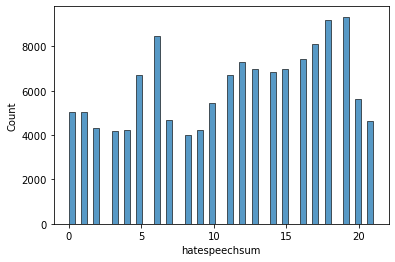

In [48]:
sns.histplot(x = 'hatespeechsum',  data = data_multi)

In [49]:
from sklearn import preprocessing

hatespeech_array = np.array(data_multi['hatespeechsum'])
hatespeech_array

array([ 0.,  1., 19., ...,  2.,  3., 15.])

In [50]:
normalized_hate = preprocessing.normalize([hatespeech_array])

In [51]:
print(normalized_hate)

[[0.         0.00020939 0.00397837 ... 0.00041878 0.00062816 0.00314082]]


In [52]:
len(normalized_hate[0])

135556

In [53]:
data_multi['normalized_hate'] = normalized_hate[0]

<AxesSubplot:xlabel='normalized_hate', ylabel='Count'>

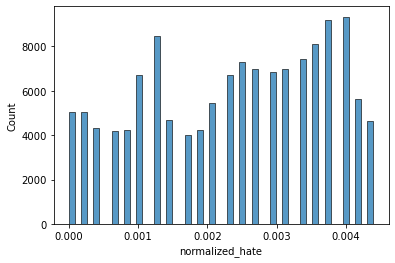

In [54]:
sns.histplot(x = 'normalized_hate', data = data_multi)

In [55]:
data_multi['normalized_hate'].value_counts()

0.003978    9335
0.003769    9202
0.001256    8485
0.003560    8119
0.003350    7423
0.002513    7303
0.003141    6970
0.002722    6963
0.002931    6853
0.001047    6726
0.002303    6718
0.004188    5609
0.002094    5454
0.000000    5062
0.000209    5052
0.001466    4683
0.004397    4624
0.000419    4306
0.000838    4249
0.001884    4222
0.000628    4190
0.001675    4008
Name: normalized_hate, dtype: int64

In [56]:
data_multi[data_multi['normalized_hate'] >= 0.002]

#i used a cut off point 
#not sure why in ormalized but itl  \ooks nice on a graph
#and it makes it easier to decide on the cut off point 
#this is called "scaling it"


,sentiment,respect,insult,humiliate,status,dehumanize,violence_phys,genocide,attack_defend,hatespeech,...,locationlatitude,locationlongitude,identity,hypothesis,polarity,polarity_binary,labels_polarity,race_label,hatespeechsum,normalized_hate
2,4.0,4.0,3.0,2.0,1.0,1.0,0.0,0.0,3.0,1.0,...,39.3361053466796875,-76.53890228271484375,0.985910,-0.207369,"{'neg': 0.172, 'neu': 0.68, 'pos': 0.148, 'com...",False,0,white,19.0,0.003978
4,4.0,4.0,3.0,2.0,1.0,1.0,1.0,0.0,2.0,1.0,...,34.215301513671875,-79.64679718017578125,0.935462,0.104225,"{'neg': 0.236, 'neu': 0.764, 'pos': 0.0, 'comp...",False,0,white,19.0,0.003978
6,4.0,4.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,1.0,...,40.6627044677734375,-73.9138031005859375,0.932548,-0.047389,"{'neg': 0.219, 'neu': 0.781, 'pos': 0.0, 'comp...",False,0,black,18.0,0.003769
7,4.0,4.0,3.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,...,39.443603515625,-104.85359954833984375,0.933526,0.446312,"{'neg': 0.699, 'neu': 0.301, 'pos': 0.0, 'comp...",False,0,white,17.0,0.003560
8,4.0,4.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,34.9250946044921875,-80.7277984619140625,0.891258,-0.199284,"{'neg': 0.103, 'neu': 0.713, 'pos': 0.184, 'co...",True,1,white,14.0,0.002931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135478,3.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,34.5487060546875,-77.94029998779296875,0.787630,0.259148,"{'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...",True,1,white,12.0,0.002513
135515,4.0,4.0,3.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,...,34.1558990478515625,-116.431304931640625,0.526959,0.469881,"{'neg': 0.0, 'neu': 0.879, 'pos': 0.121, 'comp...",True,1,white,16.0,0.003350
135531,4.0,3.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,34.0034027099609375,-84.46050262451171875,0.526959,0.469881,"{'neg': 0.0, 'neu': 0.879, 'pos': 0.121, 'comp...",True,1,white,12.0,0.002513
135532,3.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,34.000701904296875,-81.03479766845703125,0.802158,0.344536,"{'neg': 0.0, 'neu': 0.774, 'pos': 0.226, 'comp...",True,1,white,11.0,0.002303


In [57]:
len(data_multi[data_multi['normalized_hate'] >= 0.002])
#this mimicks the 1/3 and 2/3 positive negative class distinction that i talked about with Akshay Balsubramani
#but do we want it to be 50-50?
#how was the data collected initially -- let that be the leading demarcator 

84573

In [58]:
len(data_multi[data_multi['normalized_hate'] < 0.002])

50983

In [59]:
#binarized hate
data_multi['binarized_hate'] = np.where(data_multi.normalized_hate >= 0.002, 1, 0)

In [60]:
data_multi['binarized_hate'].value_counts()

1    84573
0    50983
Name: binarized_hate, dtype: int64

In [61]:
y = data_multi['binarized_hate'].values
y

array([0, 0, 1, ..., 0, 0, 1])

In [70]:
features = ['target_black', 'target_latino', 'target_asian', 'target_native american', 'target_pacific islander', 'target_white',
            'demo_asian', 'demo_black', 'demo_american_indian_alaska_native', 'demo_latino',
            'demo_white', 'demo_other_race', 'black_labeler_black_target', 'white_labeler_black_target',
            'labels_polarity']

In [63]:
X_2 = data_multi

In [64]:
X_2.rename(columns={'demo_race_ethnicitie_1': 'demo_american_indian_alaska_native',
                                       'demo_race_ethnicitie_2': 'demo_asian',
                                       'demo_race_ethnicitie_3': 'demo_black',
                                       'demo_race_ethnicitie_4': 'demo_latino',
                                       'demo_race_ethnicitie_5': 'demo_native_hawaiian_pacific_islander',
                                       'demo_race_ethnicitie_6': 'demo_white',
                                       'demo_race_ethnicitie_7': 'demo_other_race',
                                       'demo_race_ethnicitie_7_text': 'demo_other_race_text',
                                       'demo_race_ethnicitie_8': 'demo_middle_eastern',
                                       'target_race_1': 'target_black',
                                       'target_race_2': 'target_latino',
                                       'target_race_3': 'target_asian',
                                       'target_race_4': 'target_native american',
                                       'target_race_5': 'target_pacific islander',
                                       'target_race_6': 'target_white',
                                       'target_race_7': 'target_other_race',
                                       'target_race_7_text': 'target_other_race_text'}, inplace=True)

In [66]:
#black labeler, black target
X_2['black_labeler_black_target'] = X_2['target_black'] * X_2['demo_black']

#white labeler, black target

X_2['white_labeler_black_target'] = X_2['target_black'] * X_2['demo_white']

#black labeler, white target

X_2['black_labeler_white_target'] = X_2['target_white'] * X_2['demo_black']

#white labeler, white target

X_2['white_labeler_white_target'] = X_2['target_white'] * X_2['demo_white']

In [71]:
X_2 = X_2[features]

In [72]:
X_2 = pd.get_dummies(X_2)
X_2

,target_black,target_latino,target_asian,target_native american,target_pacific islander,target_white,demo_asian,demo_black,demo_american_indian_alaska_native,demo_latino,demo_white,demo_other_race,black_labeler_black_target,white_labeler_black_target,labels_polarity
0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1
135552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0
135553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0
135554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0


In [73]:
X_2 = X_2.fillna(0)

In [74]:
#making train test split here 
X_2_train, X_2_test, y_train, y_test = train_test_split(X_2, y, test_size = .25)

In [75]:
log_reg = LogisticRegression()

In [76]:
log_reg.fit(X_2_train, y_train)

LogisticRegression()

In [77]:
log_reg.coef_

array([[ 0.34089338,  0.54644873,  0.32134161, -1.49250534, -0.59413366,
        -0.15009703, -0.06609709, -0.06306147, -0.10038954, -0.04668811,
         0.00815467, -0.08835192,  0.03690027,  0.03887129, -1.7813659 ]])

In [78]:
#let's look at the test set here to see if the model is any good 

print(log_reg.score(X_2_train, y_train))

0.7257910629801214


In [79]:
print(log_reg.score(X_2_test, y_test))

0.7256041783469562


In [80]:
results = sm.Logit(y_train, X_2_train).fit()

Optimization terminated successfully.
         Current function value: 0.581582
         Iterations 5


In [81]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               101667
Model:                          Logit   Df Residuals:                   101652
Method:                           MLE   Df Model:                           14
Date:                Tue, 26 Oct 2021   Pseudo R-squ.:                  0.1212
Time:                        14:35:27   Log-Likelihood:                -59128.
converged:                       True   LL-Null:                       -67285.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
target_black                           0.7887      0.056     14.134      0.000       0.679       0.898
target_latino                          0.5953      0.037   

In [ ]:
#how should the y be defined

#made it hate speech sum normalized and then binarized into 0 1 bc i thought this would be helpful for logit 

#maybe i use the items where the y is a set of "subjective" criteria 


In [53]:
data_multi.columns.values

array(['sentiment', 'respect', 'insult', 'humiliate', 'status',
       'dehumanize', 'violence_phys', 'genocide', 'attack_defend',
       'hatespeech', 'comment_id', 'platform', 'uid', 'predict_text',
       'measure', 'std_err', 'num_ratings', 'weight', 'has_targets',
       'target_identity_count', 'labeler_id', 'rater_measure',
       'rater_infitms', 'rater_outfitms', 'infitms', 'outfitms',
       'target_identities_1', 'target_identities_2',
       'target_identities_3', 'target_identities_4',
       'target_identities_5', 'target_identities_6',
       'target_identities_7', 'target_identities_9', 'target_race_1',
       'target_race_2', 'target_race_3', 'target_race_8', 'target_race_4',
       'target_race_5', 'target_race_6', 'target_race_7',
       'target_race_7_text', 'target_religion_1', 'target_religion_2',
       'target_religion_4', 'target_religion_5', 'target_religion_8',
       'target_religion_9', 'target_religion_10', 'target_religion_6',
       'target_religion_6_te

In [54]:
items = ['sentiment', 'respect', 'insult', 'humiliate', 'status',
       'dehumanize', 'violence_phys', 'genocide', 'attack_defend',
       'hatespeech']

In [59]:
black_target_black_labeler_dehumanize = data_multi[(data_multi['target_race_1'] == 1) & (data_multi['demo_race_ethnicitie_3'])]['dehumanize']

In [60]:
black_target_white_labeler_dehumanize = data_multi[(data_multi['target_race_1'] == 1) & (data_multi['demo_race_ethnicitie_6'])]['dehumanize']

In [63]:
import statistics as s

print('black target black labeler dehumanize mean', s.mean(black_target_black_labeler_dehumanize))
print('black target white labeler dehumanize mean', s.mean(black_target_white_labeler_dehumanize))

black target black labeler dehumanize mean 0.46116928446771377
black target white labeler dehumanize mean 0.4498786734968994


In [66]:
for i in items:
    print(i, 'black target black labeler', s.mean(data_multi[(data_multi['target_race_1'] == 1) & (data_multi['demo_race_ethnicitie_3'])][i]))
    print(i, 'black target white labeler', s.mean(data_multi[(data_multi['target_race_1'] == 1) & (data_multi['demo_race_ethnicitie_6'])][i]))

    #look back at target race agreement in previous notebook

sentiment black target black labeler 3.1919720767888307
sentiment black target white labeler 3.265192774332704
respect black target black labeler 3.074607329842932
respect black target white labeler 3.1447290374764085
insult black target black labeler 1.9376090750436301
insult black target white labeler 1.9723914801833378
humiliate black target black labeler 0.955933682373473
humiliate black target white labeler 0.8925856025882988
status black target black labeler 0.5392670157068062
status black target white labeler 0.5994607710973309
dehumanize black target black labeler 0.46116928446771377
dehumanize black target white labeler 0.4498786734968994
violence_phys black target black labeler 0.27137870855148344
violence_phys black target white labeler 0.257427878134268
genocide black target black labeler 0.2111692844677138
genocide black target white labeler 0.1870045834456727
attack_defend black target black labeler 1.8656195462478184
attack_defend black target white labeler 1.85521703963

In [67]:
#average_items_black_target = {'black_labeler':{'sentiment': , 'respect': }, 'white_labeler':{} }

black_target_white_labeler = data_multi[(data_multi['target_race_1'] == 1) & (data_multi['demo_race_ethnicitie_6'])]

In [69]:
black_target_black_labeler_dehumanize = data_multi[(data_multi['target_race_1'] == 1) & (data_multi['demo_race_ethnicitie_3'])]

In [71]:
values_black = []
values_white = []
for i in items:
    values_black.append(s.mean(data_multi[(data_multi['target_race_1'] == 1) & (data_multi['demo_race_ethnicitie_3'])][i]))
    values_white.append(s.mean(data_multi[(data_multi['target_race_1'] == 1) & (data_multi['demo_race_ethnicitie_6'])][i]))

In [72]:
values_black
values_white

[3.265192774332704,
 3.1447290374764085,
 1.9723914801833378,
 0.8925856025882988,
 0.5994607710973309,
 0.4498786734968994,
 0.257427878134268,
 0.1870045834456727,
 1.8552170396333243,
 0.543273119439202]